In [12]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import numpy as np
import pandas as pd

from thinkbayes2 import Pmf, Cdf, Suite, Joint, EvalBinomialPmf, Hist
import thinkplot
import numpy as np
import random
from scipy.signal import convolve2d
from seaborn import heatmap
import matplotlib.pyplot as plt
from scipy.special import expit
from itertools import product

## Battleship Problem
In this notebook, I will revisit the problem I attempted in the last notebook. Technically I solved the part that requires Bayes' theorem, but there was some Bayesian searching to do, and I did not fully implement that. This time, I did (or at least, I made an honest effort). 

First, setup. These are all functions that were in the previous homework, but cleaned up a bit. The hunter is the class that tries to find the battleship, the Battleship class stores a hidden coordinate and decides whether or not to report a miss each time.

In [3]:
class battleship_hunter(Suite, Joint):
    def __init__(self):
        xs = np.linspace(0, 10, 11)
        pairs = []
        for x in xs:
            for y in xs:
                pairs.append((x, y))
        self.pairs = pairs
        Suite.__init__(self, pairs)
    def Likelihood(self, data, hypo):
        """
        data: a tuple containing a tuple and a Boolean, ((where we shot), hit or miss)
        hypo: Location of the ship
        """
        coord_fired, hit = data
        coord_h = hypo
        
        dist = np.linalg.norm(np.array(coord_h) - np.array(coord_fired))
        like_hit =  np.exp(-dist)
        if hit:
            return like_hit 
        else:
            return 1-like_hit

In [4]:
class Battleship():
    def __init__(self, coord=None):
        #Pick a random coordinate unless you provide one
        if coord == None:
            self.coord = (random.randint(0,10), random.randint(0,10))
        else:
            self.coord = coord
    def check_for_hit(self, attack):
        #Decides whether or not it will report a hit
        #print(self.coord)
        #print(attack)
        dist = np.linalg.norm(np.array(self.coord) - np.array(attack))
        p = np.exp(-dist)
        if random.random() < p:
            #If p (or probability of reporting hit) is really big, will usually return a hit
            return True
        else:
            return False
    def spill_secrets(self, verbose=False):
        #To find out at the end how well we did.
        if verbose == True:
            print(self.coord)
        return self.coord

In [5]:
def play_battleship(ship_type, coord=None, cert_thresh = 0.9, verbose=False):
    
    # Initialize both the ship and the hunter
    hidden_ship = Battleship(coord=coord)
    hunter = ship_type()
    
    # Begin loop. Until certain enough, keep shooting.
    certainty = 0
    shots = 0
    first_shot = True
    #print(hunter.MAP())
    while certainty < cert_thresh:
        if first_shot:
            coord, _ = hunter.next_target(first_shot)
            first_shot = False
        else:
            coord, _ = hunter.next_target(first_shot)
        hit = hidden_ship.check_for_hit(coord)
        #print("Hit:", hit)
        hunter.Update((coord, hit))
        certainty = hunter[coord] # I am sure there is a method for this but I don't know what it is.
        shots += 1
        
    
    spot = hidden_ship.spill_secrets(verbose)
    if verbose==True:
        print("Best Guess:\n", hunter.MAP())
        print("Actual result:", hidden_ship.spill_secrets())
        print("Shots required: " + str(shots))
    return shots, hunter.MAP(), spot

The most basic version just picks the MAP every time. Really, the goal is to come up with an algorithm that does better than that. 

In [6]:
class MAP_battleship_hunter(battleship_hunter):
    def next_target(self, fshot):
        if fshot:
            return (5,5)
        return self.MAP(), fshot

In [7]:
play_battleship(MAP_battleship_hunter, coord=(10,2), cert_thresh = 0.9, verbose=True)

(10, 2)
Best Guess:
 (10.0, 2.0)
Actual result: (10, 2)
Shots required: 23


(23, (10.0, 2.0), (10, 2))

If we do this enough times for each grid, we get a good idea of how well the ship performs. The simulation should play out roughly the same way if the same coordinate is chosen for the battleship, so I iterate through each space a few times and call that good.

In [63]:
def test_class(ship_type, num_runs):
    shots = []
    xs = np.linspace(0, 10, 11)
    pairs = []
    for x in xs:
        for y in xs:
            pairs.append((x, y))
    grid = np.zeros((11,11))
    for pair in pairs:
        spot_shots = 0
        for i in range(num_runs):
            shot = play_battleship(ship_type, coord=pair)[0]
            spot_shots += shot
            shots.append(shot)
        grid[int(pair[0]), int(pair[1])] = spot_shots/121
    print("Lowest:", np.amin(shots))
    print("Highest:", np.amax(shots))
    print("Mean:", np.mean(shots))
    print("Standard Deviation:", np.std(shots))
    
    heatmap(grid)

Below is the test of this class. I included a heatmap of the shots, because I thought there might be some interesting patterns associated with where each class did well. It looks mostly like random noise, with a few points (such as the center and corners) where it does pretty well. 

Lowest: 4
Highest: 121
Mean: 30.779504132231406
Standard Deviation: 18.78684636782688


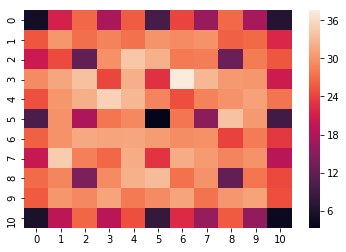

In [65]:
test_class(MAP_battleship_hunter, 100)

Finally, we can set up the convolver class. This one creates a kernel, and convolves the kernel across the grid in order to both aim for high probabilities but also shoot at useful spots. To do this, the kernel has higher weights towards the middle, and lower ones on the outside. This ensures that the hunter still aims for good spots. With even weights, it takes a very long time to find the ship.

In [18]:
class convolver(battleship_hunter):
    def next_target(self, first_shot):
        if first_shot:
            return (5,5)
        kernel = np.array([[0.25, 0.5, 0.5, 0.5, 0.25], # This kernel is designed to care less about probabilities farther from the point. 
                          [0.5, 1, 1, 1, 0.5],
                          [0.5, 1, 3, 1, 0.5],
                          [0.5, 1, 1, 1, 0.5],
                          [0.25, 0.5, 0.5, 0.5, 0.25]])
        #First, build grid of probs (can probably do with a method but whatever)
        probs = np.zeros((11,11))
        for x, px in self.Marginal(0).Items():
            for y, py in self.Marginal(1).Items():
                probs[int(y), int(x)] = self[(x,y)]
        #print(probs)
        hmap = convolve2d(probs, kernel, mode='same')
        hmap = np.array(hmap)
        h_copy = hmap # If I dont do this it breaks. Must be the max method? Maybe np.where
        best = h_copy.max()
        best_spots = np.where(h_copy==best)
        
        best_x = best_spots[1][0] # Just gonna grab the first one, they are all basically eequally good.
        best_y = best_spots[0][0]
        next_target = (best_x, best_y)
        
        return next_target, hmap
        
        

Below is a heatmap, showing the kernel in action for two shots. The heatmap shows the grid weighted by both probability and surrounding probability. As expected, it forms a ring around the outside after the first shot. The contour plot is plotted over, to give a general idea of the probabilities.

(8, 8)
False


/home/jonah/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


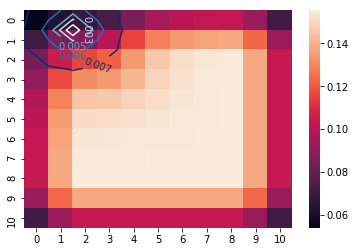

In [68]:
ship = convolver()
B = Battleship(coord=(1,1))
coord = (2,1)
data = (coord, False)
ship.Update(data=data)
thinkplot.Contour(ship)
best, hmap = ship.next_target(False)
print(best)
print(B.check_for_hit(best))
heatmap(hmap)

(8, 8)
False


/home/jonah/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


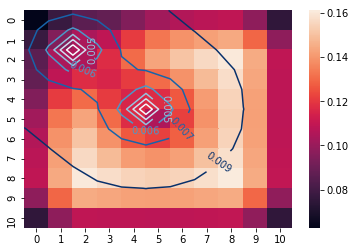

In [48]:
coord = (2,2)
data = (coord, False)
ship.Update(data=data)
thinkplot.Contour(ship)
best, hmap = ship.next_target(False)
print(best)
print(B.check_for_hit(best))
heatmap(hmap)

In [41]:
play_battleship(convolver, cert_thresh = 0.9, verbose=True);

(4, 3)
Best Guess:
 (4.0, 3.0)
Actual result: (4, 3)
Shots required: 106


Lowest: 4
Highest: 120
Mean: 29.936776859504132
Standard Deviation: 18.653536731316446


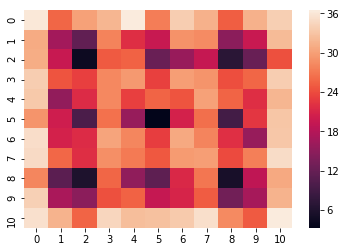

In [67]:
test_class(convolver, 100)

It looks like there might be some small amount of improvement, but not very much if that. The mean is about 0.8 lower. The heatmap does a good job revealing where the convolver does a good job, and where its bad. With this many simulations (~12000) I am somewhat willing to say that the marginal improvement is probably real, but I am not totally sure. 

So, I am disappointed in these results, and a little confused by them, as I thought there would be clear and marked improvement. Oh well. My theory is that the exponential function causes pretty much any shot that isnt a direct hit to be considerd a miss (a consequence of a rough, discrete grid), so the probabilistic nature of the game is lost somewhat. Regardless, I have now sunk too much time into this problem so I am doing something else.

## Bayesian Regression - Left vs Right handed dexterity

This problem was presented in lecture 17, asking whether left or right handed people have better dexterity. First, we need the data. Unfortunately, it was stored in a text file, so I had to do a little bit of manipulation.

In [164]:
f = open('hand-dexterity.txt', 'r')
text = f.read()
data = text.split()
data = data[8:]
times = []
speeds = []
ages = []
dom = []
gender = []
hd = []
hand_used = []
for i in range(len(data)):
    if i%7==0:
        times.append(float(data[i]))
    if i%7==1:
        speeds.append(float(data[i]))
    if i%7==2:
        if data[i]=='NA':
            ages.append(data[i])
        else:
            ages.append(float(data[i]))
    if i%7==3:
        dom.append(int(data[i]))
    if i%7==4:
        gender.append(int(data[i]))
    if i%7==5:
        hd.append(data[i])
    if i%7==6:
        hand_used.append(data[i])
        

times.pop(15)
speeds.pop(15)
ages.pop(15)
dom.pop(15)
gender.pop(15)
hd.pop(15)
hand_used.pop(15)

'R'

Now that the data is separated, I can look at it, and it seems there is definitely strong correlation between dexterity and age. I got some weird behavior when I plotted the whole dataset together, but individually it seems to work fine. Next, we test to see if there is a difference between left and right handed people's results though at this point I am skeptical, and bet there won't be). Something weird happened with the labels though, and I can't get it to go away.

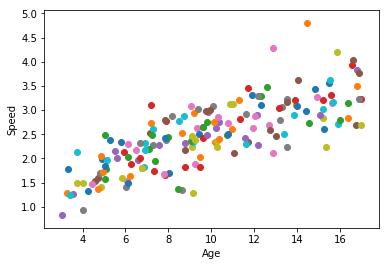

In [147]:
for i in range(len(speeds)):
    plt.scatter(ages[i], speeds[i])
plt.xlabel('Age')
plt.ylabel('Speed')
plt.show()

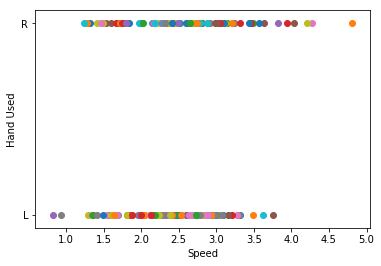

In [148]:
for i in range(len(speeds)):
    plt.scatter(speeds[i], hand_used[i])
plt.xlabel('Speed')
plt.ylabel('Hand Used')
plt.show()

From here, We can do logistic regression to check for the correlation between speed and the dominant hand being each hand. From the plot, it looks like right handed responders overall sat a little further right, but we will see what the math says.

In [149]:
class Logistic_left(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        """
        data: speed, hand
        hypo: b0, b1
        """
        speed, hand = data
        b0, b1 = hypo
        
        log_odds = b0 + b1 * speed
        p_left = expit(log_odds)
        if hand == 'L':
            return p_left
        else:
            # hand is 'R'
            return 1-p_left

In [150]:
b0 = np.linspace(-4, 4, 101) # No real idea what these should be set to, going to try this for now and see how it goes
b1 = np.linspace(-1.5, 1.5, 301)
hypos = product(b0, b1)
l_regress = Logistic_left(hypos);

In [151]:
for data in zip(speeds, hand_used):
    l_regress.Update(data)

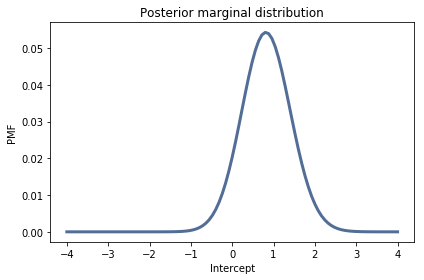

In [152]:
thinkplot.Pdf(l_regress.Marginal(0))
thinkplot.decorate(xlabel='Intercept',
                   ylabel='PMF',
                   title='Posterior marginal distribution')

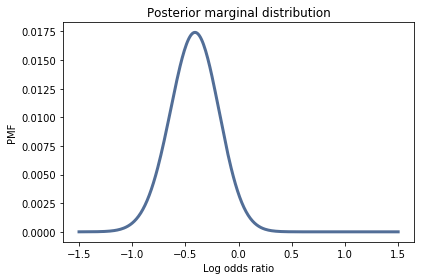

In [153]:
thinkplot.Pdf(l_regress.Marginal(1))
thinkplot.decorate(xlabel='Log odds ratio',
                   ylabel='PMF',
                   title='Posterior marginal distribution')

It looks like it's true, being left handed is correlated with lower speeds at whatever task this is.

There's a problem, though, which is that this dataset includes people who used their non-dominant hand. To me, it seems like this could be throwing off our result, especially if a lot of the people who did this happen to have the same dominant hand. To test the validity of this theory, I will remove from the dataset people who used their non-dominant hand, then try again.

In [165]:
is_to_remove = []
trimmed_speeds = speeds.copy()
trimmed_hand_used = hand_used.copy()
#print(trimmed_speeds)
for i in range(len(speeds)):
    if dom[i] == 0:
        is_to_remove.append(i)
for i in range(len(is_to_remove)):
    if i !=0:
        trimmed_speeds.pop(is_to_remove[-i])
        trimmed_hand_used.pop(is_to_remove[-i])
trimmed_speeds.pop(0)
trimmed_hand_used.pop(0)

'L'

In [166]:
b0 = np.linspace(-4, 4, 101) # No real idea what these should be set to, going to try this for now and see how it goes
b1 = np.linspace(-1.5, 1.5, 301)
hypos = product(b0, b1)
l_regress = Logistic_left(hypos);

In [167]:
for data in zip(trimmed_speeds, trimmed_hand_used):
    l_regress.Update(data)

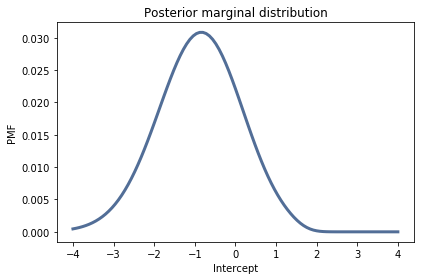

In [168]:
thinkplot.Pdf(l_regress.Marginal(0))
thinkplot.decorate(xlabel='Intercept',
                   ylabel='PMF',
                   title='Posterior marginal distribution')

0.41711853737475335


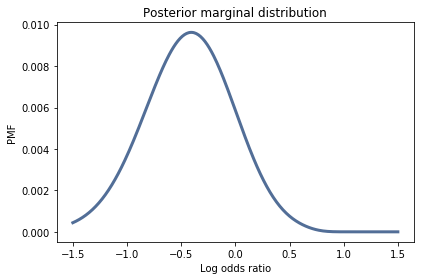

In [169]:
thinkplot.Pdf(l_regress.Marginal(1))
thinkplot.decorate(xlabel='Log odds ratio',
                   ylabel='PMF',
                   title='Posterior marginal distribution')
print(log_regress.Marginal(1).Mean())

The correlation is definitely weaker, but seems to still be there. This is interesting, and sort of surprising. 